In [1]:
%run Libraries.ipynb

In [2]:
# Importing monthly employment data
df = pd.read_csv('14100355.csv')

In [3]:
# Dropping null value
df = df.dropna(how='any',axis=0)

In [4]:
df.isnull().sum()

REF_DATE                                                 0
GEO                                                      0
North American Industry Classification System (NAICS)    0
Statistics                                               0
Data type                                                0
VALUE                                                    0
dtype: int64

In [5]:
# Selecting only necessory value from individual column
temp = df.copy()
temp = temp[temp['North American Industry Classification System (NAICS)'] == 'Total employed, all industries'].reset_index(drop=True)
temp = temp[temp['GEO'] == 'Ontario'].reset_index(drop=True)
temp = temp[temp['Statistics'] == 'Estimate'].reset_index(drop=True)
temp = temp[temp['Data type'] == 'Seasonally adjusted'].reset_index(drop=True)
Date = pd.to_datetime(temp['REF_DATE'],format='%Y/%m/%d')
temp = temp.drop(['REF_DATE', 'GEO','North American Industry Classification System (NAICS)','REF_DATE','Statistics','Data type'], axis=1)
result = pd.concat([temp], axis=1)
total_employ = result.set_index(Date)
total_employ

,VALUE
REF_DATE,
1976-01-01,3707.4
1976-02-01,3713.4
1976-03-01,3728.4
1976-04-01,3735.7
1976-05-01,3734.2
...,...
2022-01-01,7493.5
2022-02-01,7687.8
2022-03-01,7722.9


### LSTM Forecasting

In [6]:
# Defining train length
train_length = round(len(total_employ) * 0.935)
train_length

521

In [7]:
# Creating function for training and testing data
def train_test_data(total_employ, train_length):
    training_set = total_employ.iloc[0:train_length]
    testing_set = total_employ.iloc[train_length:,:]
    
    #Scaling 
    scaler = MinMaxScaler(feature_range=(0,1))
    training_set = scaler.fit_transform(training_set)
    
    x_train = []
    y_train = []
    
    for i in range(24, len(training_set)):
        x_train.append(training_set[i-24:i, 0])
        y_train.append(training_set[i, 0])
    
    #Converting into numpy array and reshaping the dimensions required for LSTM
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    
    testing_inputs = total_employ[len(total_employ) - len(testing_set) - 24:].values
    testing_inputs_scaled = scaler.transform(testing_inputs)
    
    x_test=[]
    for i in range(24, len(total_employ)-len(x_train)):
        x_test.append(testing_inputs_scaled[i-24:i, 0])
    
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = total_employ[len(training_set):]
    y_test = scaler.transform(y_test)
    
    print('The size of: \nX_train: ' +str(x_train.shape))
    print('Y_train: ' +str(y_train.shape))
    print("X_test: " + str(x_test.shape))
    print("Y_test: " +str(y_test.shape))
    
    return x_train, x_test, y_train, y_test, scaler

In [8]:
x_train, x_test, y_train, y_test, scaler = train_test_data(total_employ, train_length)

The size of: 
X_train: (497, 24, 1)
Y_train: (497,)
X_test: (36, 24, 1)
Y_test: (36, 1)


In [10]:
# Defining mean absolute percentage error
def mape(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred).reshape(-1,1)
    return np.mean((np.abs((y_test - y_pred) / y_test) * 100))

In [11]:
# Defining funcion for model loss
def plot_model_loss(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.title('Training and Validation loss')
    plt.show()

In [12]:
# Defining fuction to plot predictions
def plot_predict(model):
    global df, x_test, y_test, total_employ
    y_pred = model.predict(x_test)
    y_pred = scaler.inverse_transform(y_pred)
    train_set = total_employ[:train_length]
    valid_set = total_employ[train_length:]
    valid_set['Predicted'] = y_pred
    y_test = y_test
    print('MSE: ' +str(mse(y_test, y_pred)))
    print('RMSE: ' +str(np.sqrt(mse(y_test, y_pred))))
    print('MAE:' + str(mae(y_test, y_pred)))
    print('MAPE: ' +str(mape(y_test, y_pred)))
    plt.figure(figsize=(10,5))
    plt.plot(train_set)
    plt.plot(valid_set[['VALUE', 'Predicted']])
    plt.legend(["Train", 'Validation', 'Predict'])
    plt.ylabel('Value')
    plt.xlabel('Year')
    plt.title("Employment Forecasting using LSTM")
    plt.show()

In [13]:
# To display run-time of the model
log_dir = f"{int(time.time())}"

In [14]:
# Creating fuction for tuning LSTM model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('Initial_nodes', 64,128,2), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
    for i in range(hp.Int('n_layers_lstm', 4,8)):
        model.add(LSTM(hp.Int("inner_layers", 86,128,4), activation='tanh', return_sequences=True))
        if i % 2 ==0:
            model.add(Dropout(0.2))
    model.add(LSTM(hp.Int('Last_nodes', 32,64,4), activation='relu', return_sequences=False))
    for i in range(hp.Int('n_layers_dense', 2,3,4)):
        model.add(Dense(hp.Int('Dense_nodes', 16,32,4)))
        model.add(Dense(hp.Int('Dense_nodes2', 8,16,2)))
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='mse')
    
    return model

In [15]:
# Define and search tuner 
tuner = RandomSearch(build_model, 
                    objective='val_loss',
                    max_trials=15,
                    executions_per_trial=1,
                    directory= log_dir)
tuner.search(x=x_train, y=y_train, epochs=20,batch_size=8, validation_data=(x_test, y_test))

Trial 15 Complete [00h 02m 10s]
val_loss: 0.008140829391777515

Best val_loss So Far: 0.007996367290616035
Total elapsed time: 01h 41m 36s
INFO:tensorflow:Oracle triggered exit


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 94)            36096     
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 90)            66600     
_________________________________________________________________
dropout (Dropout)            (None, 24, 90)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 90)            65160     
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 90)            65160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 90)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 90)            6

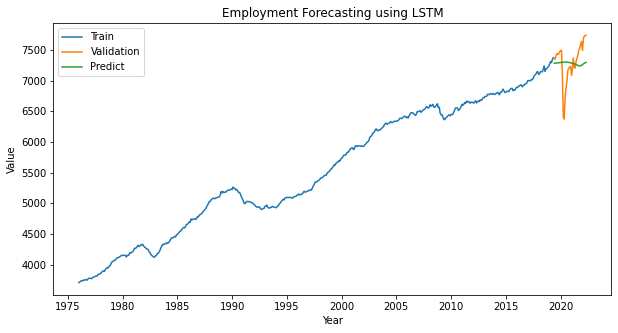

In [16]:
# Displaying best model summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
plot_predict(best_model)

### ARIMA Forecasting 

In [17]:
# Decompose the time series
def decomposing():
    global df
    industry = total_employ
    decomp = seasonal_decompose(industry)

    plt.figure(figsize=(20,8))
    decomp.plot()
    plt.show()
    return decomp

<Figure size 1440x576 with 0 Axes>

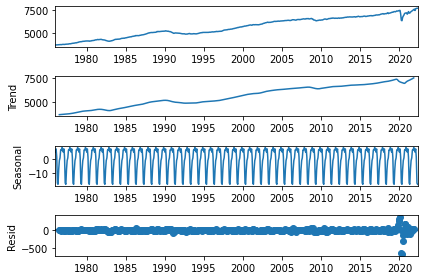

In [18]:
decomp = decomposing()

In [19]:
# Creating function to check stationarity in data
def check_stationary(industry):
    results = adfuller(industry)
    
    print("Using the Dicky Fuller Test. \n\nThe P-Value for this test is " +str(results[1]))
    if results[1] <= 0.05:
        print("Strong evidence as the p-value is under 0.05. The data is stationary")
    else:
        print("Weak evidence as the p-value is above 0.05. Time series has unit root, indicating the data is Non-Stationary")
        print("\nConverting to Stationary...")
        industry_diff = industry.diff().dropna()
        print("After Conversion")
        check_stationary(industry_diff)

In [20]:
check_stationary(total_employ)

Using the Dicky Fuller Test. 

The P-Value for this test is 0.9397984035531334
Weak evidence as the p-value is above 0.05. Time series has unit root, indicating the data is Non-Stationary

Converting to Stationary...
After Conversion
Using the Dicky Fuller Test. 

The P-Value for this test is 3.0283454448091426e-09
Strong evidence as the p-value is under 0.05. The data is stationary


In [21]:
# Function to Fit ARIMA
def fit_best_arima(data):
    auto = pm.auto_arima(data, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=12,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    
    return auto

In [22]:
# Function to forecast results
def forecast_results(results):
    forecast = results.get_forecast(steps =76)
    mean_forecast= forecast.predicted_mean
    confidence_intervals= forecast.conf_int()
    confidence_intervals
    # Select lower and upper confidence limits
    lower_limits = confidence_intervals.loc[:]
    upper_limits = confidence_intervals.loc[:]

    # Print best estimate predictions
    #print(mean_forecast2)
    return mean_forecast, lower_limits, upper_limits

In [23]:
# Function to evaluate forecast performance 
def forecast_performance():
    global df
    
    industry_test =  total_employ[(total_employ.index > '2016-01-01')]
    industry_train = total_employ[(total_employ.index <= '2016-01-01')]
    
    auto = fit_best_arima(industry_train)
    
    best_sarimax = SARIMAX(industry_train, order=auto.order, seasonal_order=auto.seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False, dynamic =True)
    
    results = best_sarimax.fit()
    mean_forecast, lower_limits, upper_limits = forecast_results(results)
    
    plt.figure(figsize=(18,9))
    plt.plot(industry_train.index, industry_train, label='observed')
    
    plt.plot(industry_test.index, industry_test, label='Testing')
    #plt.legend(["Train","Validation","Predict"])
    plt.legend(["Train","Validation","Predict"],loc ="lower right")
    plt.ylabel('Value')
    plt.xlabel('Year')
    plt.title("Employment Forecasting using ARIMA")
        
    plt.plot(mean_forecast.index, mean_forecast, color='green')
    
    y_pred = mean_forecast[:]
    y_test = industry_test
    
    print('MSE: ' +str(mse(y_test, y_pred)))
    print('RMSE: ' +str(np.sqrt(mse(y_test, y_pred))))
    print('MAE:' + str(mae(y_test, y_pred)))
    print('MAPE: ' +str(mape(y_test, y_pred)))


MSE: 48588.06408322379
RMSE: 220.42700397914905
MAE:152.0223374566854
MAPE: 2.1178491783914546


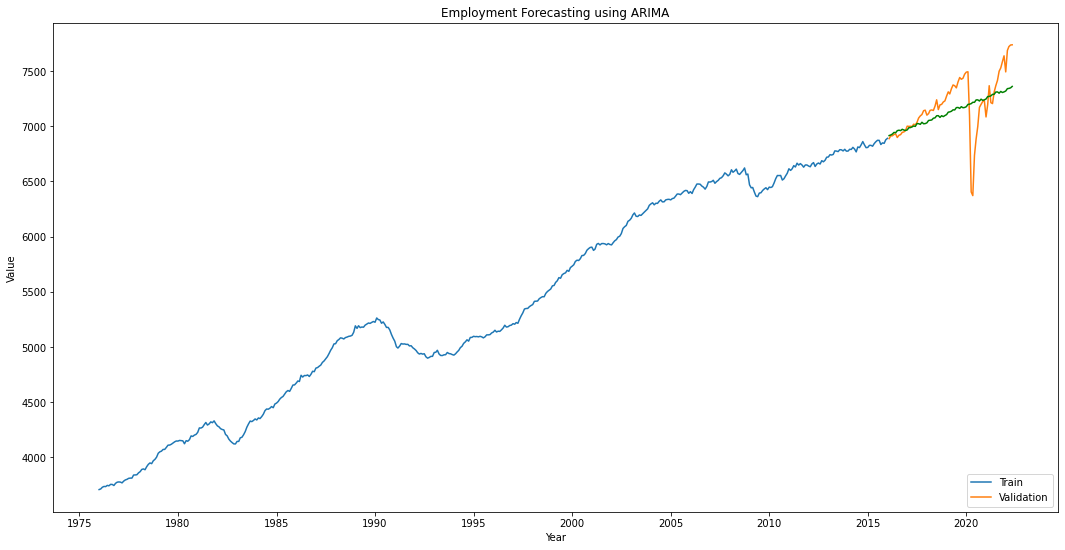

In [24]:
forecast_performance()